## Recommender systems

**Benefits of using recommender system:**
1. Link the users to the right products.
2. Increase user engagement.
3. Make personalized contents/ads.

**Types of recommendations:**
1. Popularity based recommender system: Recommend items based on ratings from most people.
2. Classification model based recommender system: Using classification model to determine if user will like the product.
3. Content based recommender system: Assume that user would like items that are similar to other items.  
4. Collaborative filtering: Assume that people likes things similar to other things they like, and things that are liked by other people with similar taste. i) User-user, ii) item-item
5. Hybrid approach: Combination of collaborative filtering, content-based filtering, and other approaches.
6. Association rule mining: Association rules capture the relationships between items based on their patterns of co-occurrence across transactions.


In [1]:
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline


In [2]:
dat = pd.read_csv("ratings_Electronics.csv", names=['userID', 'productID', 'Rating', 'timeStamp'])

In [3]:
print(dat.shape)
dat.head()

(7824482, 4)


,userID,productID,Rating,timeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
# Take subset of the data

dat = dat.iloc[:1000000, :]

In [5]:
dat.dtypes

userID        object
productID     object
Rating       float64
timeStamp      int64
dtype: object

In [6]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userID     1000000 non-null  object 
 1   productID  1000000 non-null  object 
 2   Rating     1000000 non-null  float64
 3   timeStamp  1000000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 30.5+ MB


In [7]:
dat.isnull().sum()

userID       0
productID    0
Rating       0
timeStamp    0
dtype: int64

In [8]:
dat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,1000000.0,3.973620e+00,1.399741e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timeStamp,1000000.0,1.246846e+09,1.100104e+08,912729600.0,1.168301e+09,1.246666e+09,1.355184e+09,1.406074e+09


In [9]:
print("Total unique users: ", len(np.unique(dat.userID)))
print("Total unique products: ", len(np.unique(dat.productID)))

Total unique users:  754153
Total unique products:  59634


In [10]:
dat = dat.drop(columns=['timeStamp'])
dat.head()

,userID,productID,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Ratings

<AxesSubplot:xlabel='Rating', ylabel='count'>

Text(0.5, 1.0, 'Ratings distribution plot')

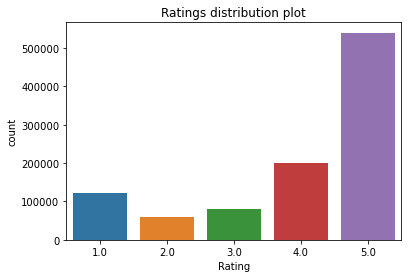

In [11]:
# Countplot for ratings

sns.countplot(data=dat, x='Rating')
plt.title('Ratings distribution plot')

### Analyzing the Ratings

In [12]:
rated_products_per_user = dat.groupby(by='userID')['Rating'].count().sort_values(ascending=False)
rated_products_per_user.head()

userID
A5JLAU2ARJ0BO     409
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      138
AT6CZDCP4TRGA     125
Name: Rating, dtype: int64

In [13]:
rated_products_per_user.describe()

count    754153.000000
mean          1.325991
std           1.372250
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         409.000000
Name: Rating, dtype: float64

In [14]:
print("Total unique users:", len(rated_products_per_user))
print("Users that have more than one ratings:", len(rated_products_per_user[rated_products_per_user > 1]))
print("Users that have more than five ratings:", len(rated_products_per_user[rated_products_per_user > 5]))
print("Users that have more than ten ratings:", len(rated_products_per_user[rated_products_per_user > 10]))
print("Users that have more than twenty ratings:", len(rated_products_per_user[rated_products_per_user > 20]))
print("Users that have more than fifty ratings:", len(rated_products_per_user[rated_products_per_user > 50]))

Total unique users: 754153
Users that have more than one ratings: 128997
Users that have more than five ratings: 7965
Users that have more than ten ratings: 1699
Users that have more than twenty ratings: 316
Users that have more than fifty ratings: 36


In [15]:
product_rating_count = dat.groupby(by='productID')['Rating'].count().sort_values(ascending=False)
product_rating_count.head()

productID
B0002L5R78    9487
B0001FTVEK    5345
B000BQ7GW8    4275
B00007E7JU    3523
B000BKJZ9Q    3219
Name: Rating, dtype: int64

In [16]:
product_rating_count.describe()

count    59634.000000
mean        16.768957
std         87.750175
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max       9487.000000
Name: Rating, dtype: float64

In [17]:
print("Total unique products:", len(product_rating_count))
print("Products that have more than five ratings:", len(product_rating_count[product_rating_count > 5]))
print("Products that have more than ten ratings:", len(product_rating_count[product_rating_count > 10]))
print("Products that have more than fifty ratings:", len(product_rating_count[product_rating_count > 50]))
print("Products that have more than one hundred ratings:", len(product_rating_count[product_rating_count > 100]))
print("Products that have more than one thousand ratings:", len(product_rating_count[product_rating_count > 1000]))

Total unique products: 59634
Products that have more than five ratings: 21054
Products that have more than ten ratings: 13612
Products that have more than fifty ratings: 3570
Products that have more than one hundred ratings: 1695
Products that have more than one thousand ratings: 71


## Popularity Based Recommendation

**Method one:** Select products in database that have the most rating counts and recommend those products to customers

In [18]:
# Top 10 rated products in dataset
popularity_based_product = dat.groupby(by='productID')['Rating'].count().sort_values(ascending=False)
popularity_based_product_top_ten = popularity_based_product[:10]

product_rating_dict = {"Product": [], "Rating": []}

for product in popularity_based_product_top_ten.index:
    rating = dat[dat.productID == product].Rating.mean()   
    product_rating_dict['Product'].append(product)
    product_rating_dict['Rating'].append(rating)

In [19]:
popularity_based_recommended_list = pd.DataFrame(product_rating_dict)
popularity_based_recommended_list

,Product,Rating
0,B0002L5R78,4.448614
1,B0001FTVEK,4.007109
2,B000BQ7GW8,4.553216
3,B00007E7JU,4.565995
4,B000BKJZ9Q,4.440509
5,B000B9RI14,4.775701
6,B000A6PPOK,3.950495
7,B00007M1TZ,3.976610
8,B00004ZCJE,4.123675
9,B000CSWCQA,4.432610


**Method two:** Select products that have more than 1000 rating counts and recommend products that have highest ratings to customers 

In [20]:
product_rating_count = dat.groupby(by='productID')['Rating'].count().sort_values(ascending=False)

product_rating_more_than_one_thousand = product_rating_count[product_rating_count > 1000]

In [21]:
product_rating_more_than_one_thousand

productID
B0002L5R78    9487
B0001FTVEK    5345
B000BQ7GW8    4275
B00007E7JU    3523
B000BKJZ9Q    3219
              ... 
B00081A2KY    1012
B000CRT07U    1011
B00022OBO2    1011
B00004SB92    1006
B000067O5G    1003
Name: Rating, Length: 71, dtype: int64

In [22]:
product_rating_dict_2 = {"Product": [], "Rating": []}

for product in product_rating_more_than_one_thousand.index:
    rating = dat[dat.productID == product].Rating.mean()   
    product_rating_dict_2['Product'].append(product)
    product_rating_dict_2['Rating'].append(rating)

In [23]:
# For products that have more than 1000 ratings, we recommend to top 10 products based on average ratings
popularity_based_recommended_list_2 = pd.DataFrame(product_rating_dict_2)
popularity_based_recommended_list_2 = popularity_based_recommended_list_2.sort_values(by='Rating', ascending=False)
popularity_based_recommended_list_2 = popularity_based_recommended_list_2[0:10]
popularity_based_recommended_list_2

,Product,Rating
5,B000B9RI14,4.775701
18,B000CKVOOY,4.707955
53,B00005LEN4,4.665763
50,B0002Y5WZM,4.662780
42,B000AJIF4E,4.641779
40,B00005T3G0,4.609946
28,B00001WRSJ,4.609079
57,B00017LSPI,4.583874
3,B00007E7JU,4.565995
32,B0002KVQBA,4.565737


## Collaborative Filtering

**Model-based approach**

In [24]:
product_rating_more_than_fifty = dat.groupby("productID").filter(lambda x:x['Rating'].count() >=50)

In [25]:
ratings_matrix = product_rating_more_than_fifty.head(10000).pivot_table(values='Rating', index='userID', columns='productID', fill_value=0)
ratings_matrix

productID,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userID,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZXP46IB63PU8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZYTSU42BZ7TP,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZZGJ2KMWB7R,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X = ratings_matrix.transpose()
X.tail()

userID,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productID,,,,,,,,,,,,,,,,,,,,,
B00000JPPI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
B00000JSGF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00000JYLO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00000JYWQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00000K135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
SVD = TruncatedSVD(n_components=5)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 5)

**Using correlation matrix for recommendation**

In [28]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [29]:
def recommend(i):
    product_names = list(X.index)
    product_ID = product_names.index(i)
    correlation_product_ID = correlation_matrix[product_ID]
    Recommend = pd.DataFrame({"ProductID": X.index, "Correlation": correlation_product_ID})
    Recommend = Recommend.sort_values(by="Correlation", ascending=False)
    Recommend = Recommend.drop(index=product_ID)
    Recommend = Recommend.iloc[:10,:]
    Recommend = Recommend.reset_index(drop=True)
    return Recommend

In [30]:
recommend("B00000K135")

,ProductID,Correlation
0,B00000J4GE,0.983099
1,6301977173,0.941936
2,B00000JCTO,0.938734
3,B00000JMUG,0.906328
4,B00000J4EY,0.893059
5,B00000IGBF,0.892814
6,9573212919,0.884552
7,B00000J4FS,0.871860
8,3744295508,0.869769
9,B00000JYLO,0.860507


In [31]:
recommend("B00000JPPI")

,ProductID,Correlation
0,B000001ON6,0.965486
1,7214047977,0.942204
2,B00000J1SC,0.890383
3,B00000JFIF,0.867535
4,B00000JBAT,0.862879
5,9984984354,0.862168
6,B00000JII6,0.860505
7,B00000JHWX,0.853179
8,9985511476,0.845564
9,B00000J0D8,0.822306


**Using cosine similarity for recommendation**

In [32]:
cosine_matrix = cosine_similarity(decomposed_matrix)

In [33]:
def recommend_cosine(i):
    product_names = list(X.index)
    product_ID = product_names.index(i)
    cosine_product_ID = cosine_matrix[product_ID]
    Recommend = pd.DataFrame({"ProductID": X.index, "Cosine_similarity": cosine_product_ID})
    Recommend = Recommend.sort_values(by="Cosine_similarity", ascending=False)
    Recommend = Recommend.drop(index=product_ID)
    Recommend = Recommend.iloc[:10,:]
    Recommend = Recommend.reset_index(drop=True)
    return Recommend

In [34]:
recommend_cosine("B00000K135")

,ProductID,Cosine_similarity
0,B00000J4GE,0.982322
1,6301977173,0.942295
2,B00000JCTO,0.938649
3,B00000IGBF,0.880511
4,9573212919,0.878980
5,B00000J4EY,0.877665
6,3744295508,0.858480
7,B00000J4FS,0.855544
8,B00000JMUG,0.841525
9,8862935293,0.839887


In [35]:
recommend_cosine("B00000JPPI")

,ProductID,Cosine_similarity
0,B000001ON6,0.965999
1,7214047977,0.931617
2,B00000J1SC,0.870763
3,B00000JFIF,0.870467
4,B00000JBAT,0.865846
5,B00000JII6,0.861371
6,9984984354,0.856068
7,9985511476,0.829405
8,B00000JHWX,0.797548
9,B00000J0D8,0.757272


**We can see there are much similar recommendation from these two recommendation engines.**